# Expressing an Auto-Regressive Language Model (AR-LM) as an RL Policy

Auto-Regressive Language Models (AR-LMs) generate sequences by modeling:

$$
P(x_1, x_2, \dots, x_T) = \prod_{t=1}^{T} P(x_t|x_{<t})
$$

We can interpret an AR-LM as a **policy $\pi_\theta(a_t|s_t)$** in a reinforcement learning setting:

- $s_t$: the current context (previous tokens or pixels)
- $a_t$: next token or pixel
- $\pi_\theta(a_t|s_t)$: the AR-LM probability distribution
- Reward: feedback signal based on sequence quality (e.g., likelihood, human preference, or similarity to target)


## 1. Policy Formulation

An AR-LM can be seen as a policy:

$$
\pi_\theta(a_t|s_t) = P_\theta(x_t|x_{<t})
$$

The **expected return** for a generated sequence of length $T$ is:

$$
J(\theta) = \mathbb{E}_{a_1, \dots, a_T \sim \pi_\theta} \Big[ \sum_{t=1}^{T} r_t \Big]
$$

Where $r_t$ is the reward at step $t$.

---

## 2. Policy Gradient Update (REINFORCE)

Using the Policy Gradient Theorem:

$$
\nabla_\theta J(\theta) = \mathbb{E}_{\pi_\theta} \Bigg[ \sum_{t=1}^{T} \nabla_\theta \log \pi_\theta(a_t|s_t) \cdot R_t \Bigg]
$$

- $R_t = \sum_{k=t}^{T} r_k$ is the cumulative reward from step $t$.
- This allows updating the AR-LM **directly from rewards** without needing supervised targets.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# Toy MNIST environment: each "action" predicts a pixel intensity [0,1]
target_sequence = np.random.rand(10)  # target pixel sequence of length 10

def reward_function(action, target):
    """Reward is negative squared error to the target pixel."""
    return - (action - target)**2


We model the AR-LM as a Gaussian policy for simplicity:

$$
a_t \sim \pi_\theta(a_t|s_t) = \mathcal{N}(\mu_\theta(s_t), \sigma^2)
$$

- $\mu_\theta(s_t)$ is predicted by the model (for simplicity we initialize it as zeros)
- Gradient of log-probability:

$$
\nabla_\theta \log \pi_\theta(a_t|s_t) = \frac{a_t - \mu_\theta(s_t)}{\sigma^2}
$$


In [2]:
seq_len = len(target_sequence)
sigma = 0.2
eta = 0.05
mu_theta = np.zeros(seq_len)  # initial AR-LM predictions
mu_history = []
reward_history = []

episodes = 50

for ep in range(episodes):
    actions = np.random.normal(mu_theta, sigma)  # sample sequence
    rewards = np.array([reward_function(a, t) for a, t in zip(actions, target_sequence)])
    cumulative_reward = rewards.sum()

    # Policy gradient update
    grad_log = (actions - mu_theta) / sigma**2
    mu_theta += eta * grad_log * rewards  # elementwise update

    # Store for visualization
    mu_history.append(mu_theta.copy())
    reward_history.append(cumulative_reward)

    print(f"Episode {ep+1}: Cumulative Reward={cumulative_reward:.4f}")


Episode 1: Cumulative Reward=-4.5716
Episode 2: Cumulative Reward=-4.0375
Episode 3: Cumulative Reward=-3.6189
Episode 4: Cumulative Reward=-1.5059
Episode 5: Cumulative Reward=-1.7579
Episode 6: Cumulative Reward=-1.1917
Episode 7: Cumulative Reward=-0.9273
Episode 8: Cumulative Reward=-1.2595
Episode 9: Cumulative Reward=-1.1000
Episode 10: Cumulative Reward=-1.3371
Episode 11: Cumulative Reward=-1.2604
Episode 12: Cumulative Reward=-1.1109
Episode 13: Cumulative Reward=-0.5984
Episode 14: Cumulative Reward=-0.6035
Episode 15: Cumulative Reward=-0.4205
Episode 16: Cumulative Reward=-0.6785
Episode 17: Cumulative Reward=-0.5409
Episode 18: Cumulative Reward=-0.7298
Episode 19: Cumulative Reward=-0.6243
Episode 20: Cumulative Reward=-0.4187
Episode 21: Cumulative Reward=-0.6525
Episode 22: Cumulative Reward=-1.2508
Episode 23: Cumulative Reward=-0.9168
Episode 24: Cumulative Reward=-0.5225
Episode 25: Cumulative Reward=-0.9845
Episode 26: Cumulative Reward=-1.3394
Episode 27: Cumulativ

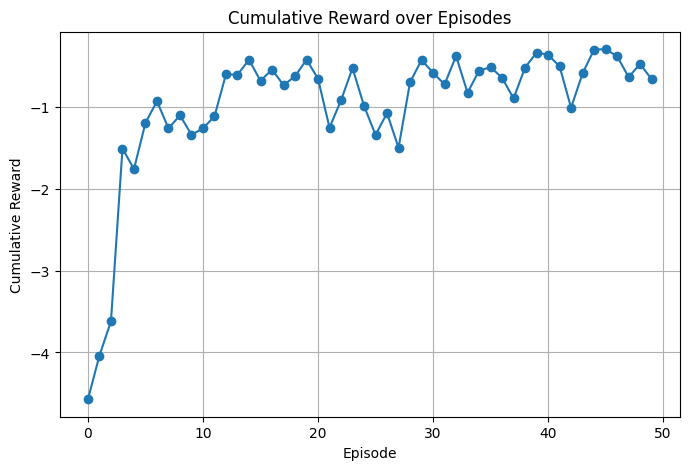

In [3]:
plt.figure(figsize=(8,5))
plt.plot(reward_history, marker='o')
plt.title("Cumulative Reward over Episodes")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.grid()
plt.show()


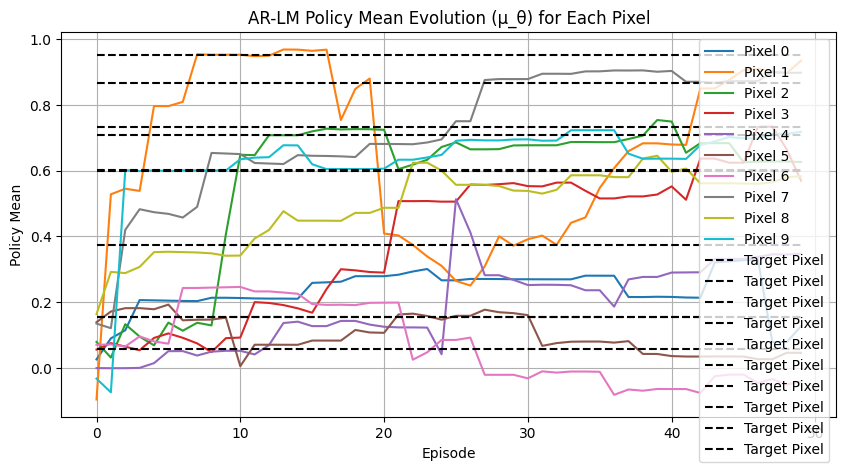

In [4]:
mu_history_arr = np.array(mu_history)

plt.figure(figsize=(10,5))
for i in range(seq_len):
    plt.plot(mu_history_arr[:,i], label=f'Pixel {i}')
plt.plot([0, episodes-1], [target_sequence, target_sequence], '--', color='black', label='Target Pixel')
plt.title("AR-LM Policy Mean Evolution (μ_θ) for Each Pixel")
plt.xlabel("Episode")
plt.ylabel("Policy Mean")
plt.legend()
plt.grid()
plt.show()


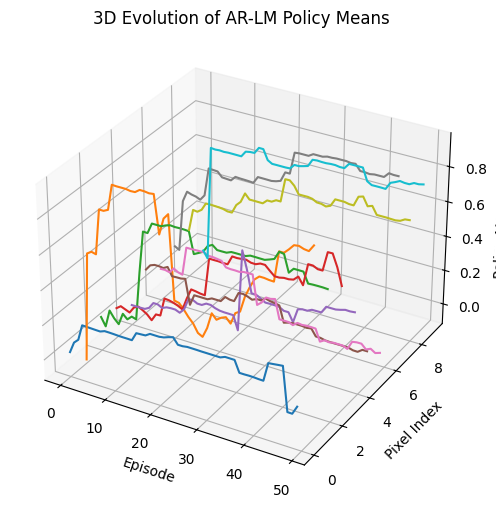

In [5]:
from mpl_toolkits.mplot3d import Axes3D

episodes_grid = np.arange(episodes)
pixels_grid = np.arange(seq_len)
mu_history_arr = np.array(mu_history)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

for i in range(seq_len):
    ax.plot(episodes_grid, [i]*episodes, mu_history_arr[:,i])

ax.set_xlabel("Episode")
ax.set_ylabel("Pixel Index")
ax.set_zlabel("Policy Mean μ_θ")
ax.set_title("3D Evolution of AR-LM Policy Means")
plt.show()


## Interpretation

1. Initially, AR-LM predicts μ_θ close to 0 for all pixels.
2. With policy gradient updates, μ_θ moves closer to target pixel intensities.
3. Reward improves as μ_θ aligns with the target sequence.

---

## Use Case in Generative AI

- Treat AR-LM as an RL policy for sequence generation.
- Rewards can represent human feedback (RLHF) or task-specific objectives.
- This method allows fine-tuning pre-trained AR-LMs **without explicit supervised labels**, directly optimizing for desirable outputs.
